In [1]:
import os
import csv
import cv2
import numpy as np
from PIL import Image
import sklearn
from random import shuffle

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [3]:
csv_file  = './data/driving_log.csv'
path = './data/' # fill in the path to your training IMG directory

In [4]:
samples = []
with open(csv_file) as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)
    for line in reader:
        samples.append(line)
print('Done')

Done


In [5]:
shuffle(samples)

In [6]:
images = []
angles = []
for batch_sample in samples:
    steering_center = float(batch_sample[3].strip())

    # create adjusted steering measurements for the side camera images
    correction = 0.2 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras         
    img_center = np.array(Image.open(path + batch_sample[0].strip()))
    img_left = np.array(Image.open(path + batch_sample[1].strip()))
    img_right = np.array(Image.open(path + batch_sample[2].strip()))

    # add images and angles to data set
    images.extend((img_center, img_left, img_right, np.fliplr(img_center), np.fliplr(img_left), np.fliplr(img_right)))
    angles.extend((steering_center, steering_left, steering_right, -steering_center, -steering_left, -steering_right))
    break

6
(6, 160, 320, 3)


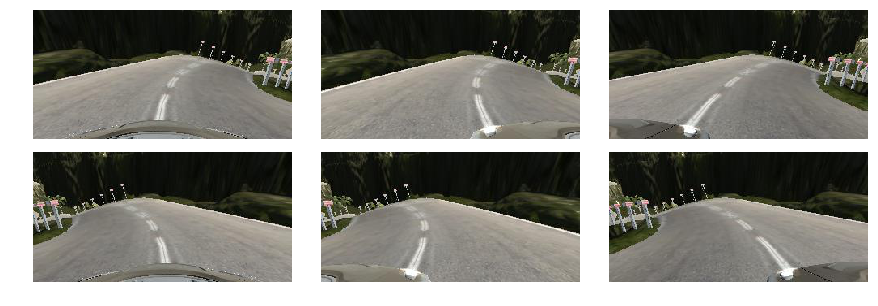

[0.0, 0.2, -0.2, -0.0, -0.2, 0.2]


In [7]:
print(len(images))
images = np.array(images)
print(images.shape)
import matplotlib.pyplot as plt
plt.rcdefaults()
%matplotlib inline

i=1
fig = plt.figure(figsize=(15, 5))
for image in images:
    plt.subplot(2, 3, i)   
    plt.imshow(image)
    plt.axis('off')
    i+=1
fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

print(angles)

In [8]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2) 

In [9]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                steering_center = float(batch_sample[3].strip())

                # create adjusted steering measurements for the side camera images
                correction = 0.2 # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction
        
                # read in images from center, left and right cameras         
                img_center = np.array(Image.open(path + batch_sample[0].strip()))
                img_left = np.array(Image.open(path + batch_sample[1].strip()))
                img_right = np.array(Image.open(path + batch_sample[2].strip()))
        
                # add images and angles to data set
                images.extend((img_center, img_left, img_right, np.fliplr(img_center), np.fliplr(img_left), np.fliplr(img_right)))
                angles.extend((steering_center, steering_left, steering_right, -steering_center, -steering_left, -steering_right))                

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [10]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

In [12]:
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [14]:
model.compile(optimizer='adam', loss='mse')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6, validation_data=validation_generator, nb_val_samples=len(validation_samples)*6, nb_epoch=5)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/5
76674/76674 [==============================] - 107s - loss: 0.1191 - val_loss: 0.1066
Epoch 2/5
76674/76674 [==============================] - 97s - loss: 0.1023 - val_loss: 0.1065
Epoch 3/5
76674/76674 [==============================] - 97s - loss: 0.0998 - val_loss: 0.0997
Epoch 4/5
76674/76674 [==============================] - 97s - loss: 0.0973 - val_loss: 0.0991
Epoch 5/5
76674/76674 [==============================] - 96s - loss: 0.0953 - val_loss: 0.0967


In [15]:
model.save('model.h5')

In [14]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')
plot(model,show_shapes=True, to_file='modelwithshapes.png')

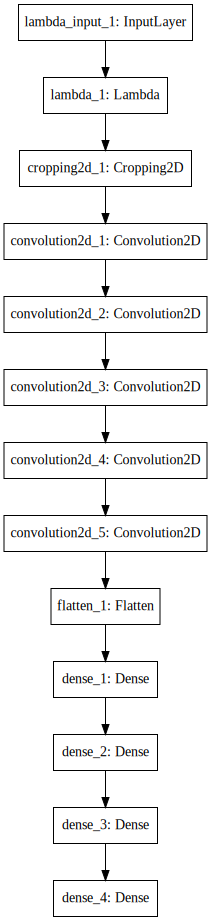

In [16]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

dict_keys(['loss', 'val_loss'])


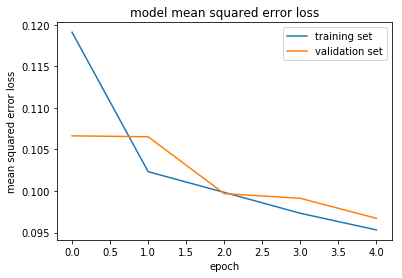

In [20]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()